# Exploratory Data Analysis (EDA) 

In [1]:
# TO DO: fix requirements.txt file 
# It would be cool to recode locations into for example postal codes, so that we later can see them on a map in Tableau
# Remember that virtual environment is salary_env

## Imports

In [2]:
# Standard library imports 
import os
import sys 

# Third-party imports 
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Local imports 
import utils.preprocessor as mf
import utils.plotting as pf
import utils.analysis as af
import utils.text_parser as tf
import utils.salary_extractor as sf
import utils.dictionaries as dicts

# Activate autoreload for custom modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

# File path definitions
DATA_PATH = os.getenv('DATA_PATH', 'data/') 
MISSING = os.path.join(DATA_PATH, 'df_FRA_missing_data.csv')
         
COUNTRIES = ['Sweden', 'France', 'Italy'] 

In [3]:
# Check we're in the right environment
print(sys.executable)

/Users/emmafrid/Documents/GitHub/portfolio-projects/job-listings-scraper/salary_env/bin/python


## Load data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [4]:
# Import csv files with scraped data for resp. country 
dfs = {country: pd.read_csv(os.path.join(DATA_PATH, f'indeed_jobs_{country}.csv')) for country in COUNTRIES}

# Add USA data to the dictionary
dfs['USA'] = mf.merge_US_cities(['NY', 'LA', 'CHI'], os.path.join(DATA_PATH, 'indeed_jobs_'))

# Access individual country data as needed, e.g., dfs['Sweden']

Loaded data for NY
Column order for consistency: ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial data inspection

In [5]:
dfs['Sweden'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [6]:
dfs['France'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [7]:
dfs['Italy'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [8]:
dfs['USA'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [9]:
# Check dimensions of dfs 
shapes = pd.DataFrame({
   'Country': dfs.keys(),
   'Columns': [df.shape[1] for df in dfs.values()],
   'Rows': [df.shape[0] for df in dfs.values()]
})
print(shapes.to_string())

  Country  Columns  Rows
0  Sweden       10   320
1  France       10  2200
2   Italy       10   769
3     USA       10  1317


In [10]:
# Check data types
dfs['Sweden'].info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [11]:
# Retrieve dictionary with preferred types 
# Convert object columns to strings to optimize performance
# Mixed columns with both numbers and strings should be kept as object, e.g.: company_location, salary, job_link
dicts.dtype_dict

{'page': 'int64',
 'country': 'string',
 'job_link': 'object',
 'search_keyword': 'category',
 'search_location': 'string',
 'job_title': 'string',
 'company_name': 'string',
 'company_location': 'object',
 'salary': 'object',
 'job_description': 'string'}

In [12]:
# Convert columns to preferred data type
dfs = {country: df.astype(dicts.dtype_dict) for country, df in dfs.items()}
# Verify
print(dfs['Sweden'].dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [13]:
dfs['Sweden'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   page              320 non-null    int64   
 1   country           320 non-null    string  
 2   job_link          320 non-null    object  
 3   search_keyword    320 non-null    category
 4   search_location   320 non-null    string  
 5   job_title         320 non-null    string  
 6   company_name      320 non-null    string  
 7   company_location  320 non-null    object  
 8   salary            320 non-null    object  
 9   job_description   320 non-null    string  
dtypes: category(1), int64(1), object(3), string(5)
memory usage: 23.1+ KB


## Data Quality Assessment

Overall: 
- The following columns needs to be cleaned: _search_keyword, job_title, job_description, company_location_.   
- The _salary_ column should be split into separate columns, with min and max salary value.   
- Text data in column _job_description_ needs normalization. 

### Missing values

In [14]:
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
for country, df in dfs.items():
    dfs[country] = df.replace('Not available', np.nan)

nan_counts = {country: df.isnull().sum() for country, df in dfs.items()}

for country, counts in nan_counts.items():
   print(f'Missing values for {country}:\n{counts}\n')

Missing values for Sweden:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              183
job_description       0
dtype: int64

Missing values for France:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64

Missing values for Italy:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              746
job_description       0
dtype: int64

Missing values for USA:
page                 0
country              0
job_link             0
search_keyword       0
search_location      0
job_title          

Salary data will be cleaned and examined in detail later. It makes sense that so many values are missing since few job listings actually included salary info. For now we do not drop these rows.

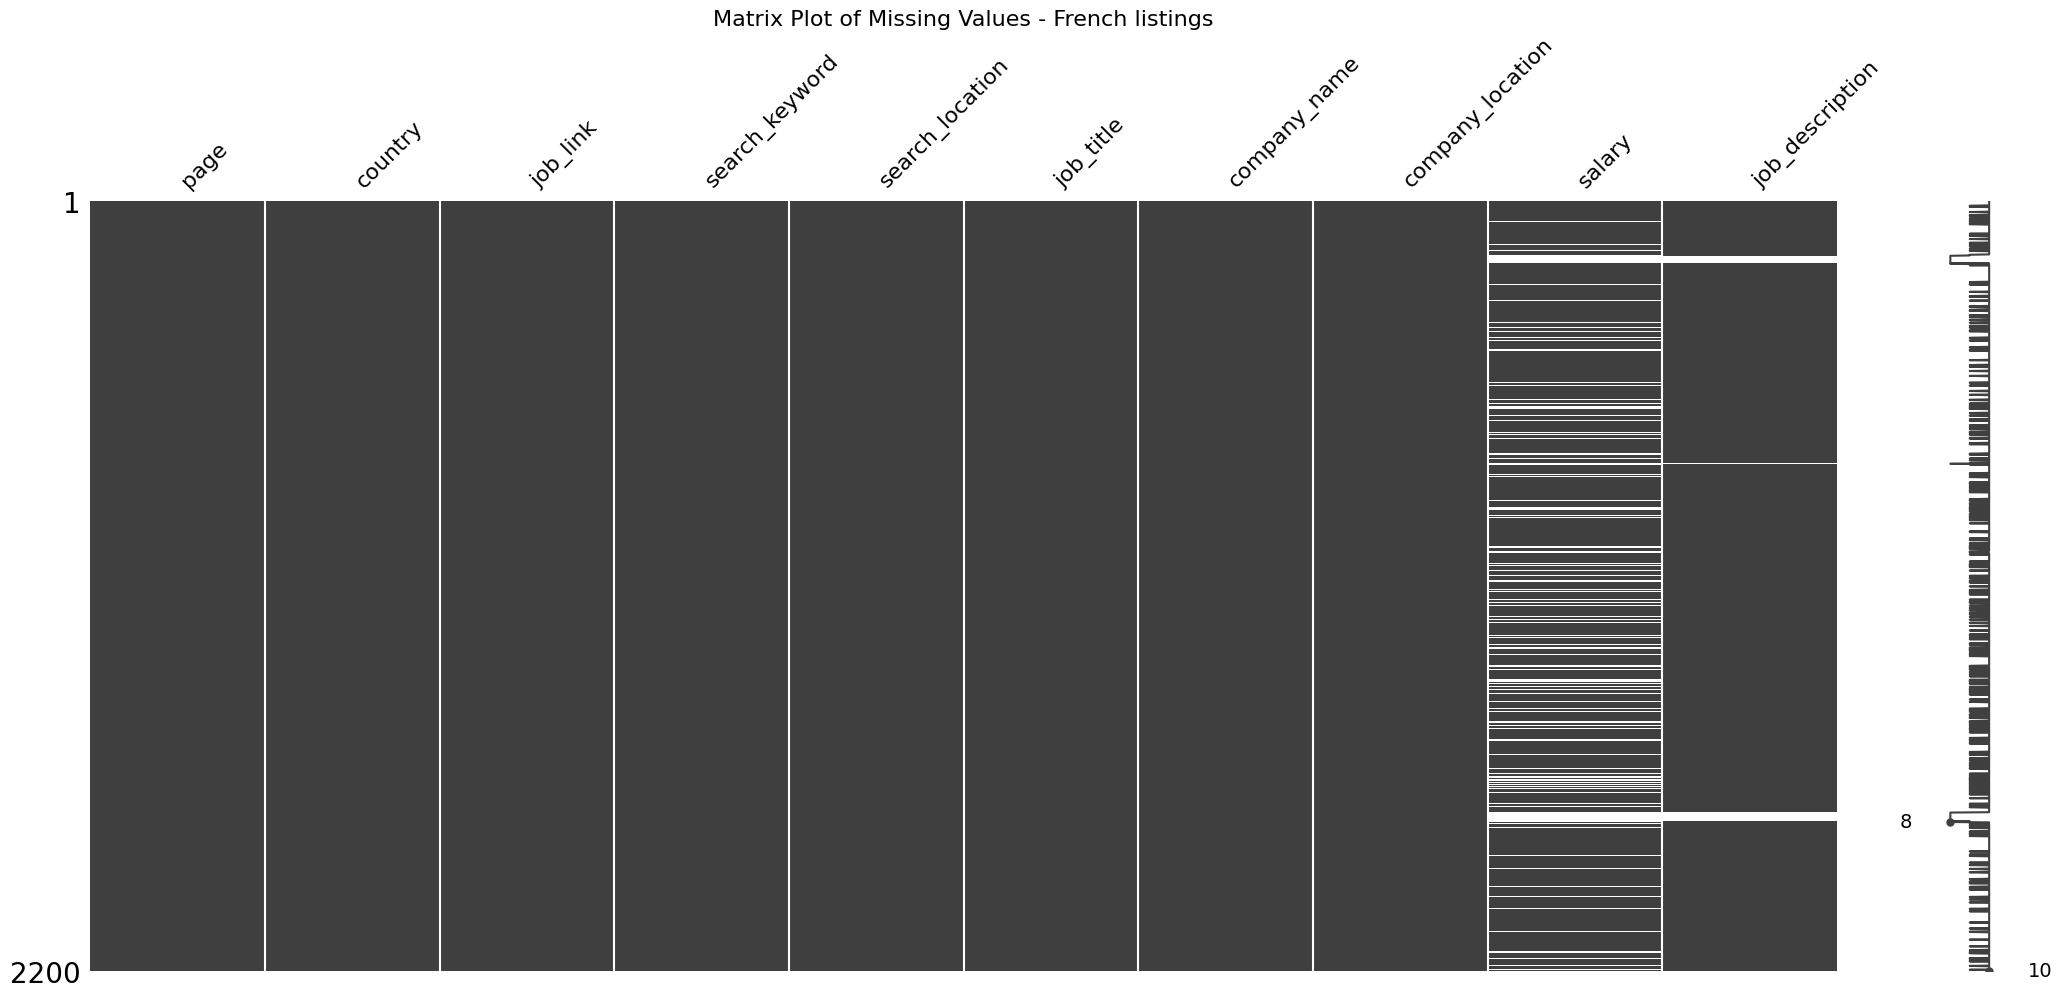

In [15]:
# Visualize missing data patterns 
msno.matrix(dfs['France']) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16) 
plt.show()

In [16]:
# Look into the missing descriptions for French job listings (scraper requests seems to have been blocked here?)
print(dfs['France'].isnull().sum())
#dfs['France'][dfs['France']['job_description'].isnull()].head()

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64


In [17]:
# Manual import of missing job description data retrieved directly from URLs 
df_FRA_missing = pd.read_csv(MISSING)
df_FRA_missing.head(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description_new
0,11,France,https://www.indeed.fr/rc/clk?jk=cce878d76d9b30...,Data+Analyst,Paris (75),Business Analyst Customer Data 360 H/F,AIR FRANCE KLM,Roissy-en-France (95),CDI,Air France KLM recrute :\n\nVous rejoignez l'é...
1,11,France,https://www.indeed.fr/rc/clk?jk=56a9127952012f...,Data+Analyst,Paris (75),Senior Data Analyst - Paris,Aircall,Paris (75),NaN,Paris\nG&A – 13008 - Data /\nFull Time /\nHybr...
2,11,France,https://www.indeed.fr/rc/clk?jk=f43bcf87ea7bcd...,Data+Analyst,Paris (75),Marketing Business Analyst - (CDD 6 mois),Deliveroo,Paris (75),NaN,Why Deliveroo\n\nOur mission is to transform t...


In [18]:
# Merge French data frames based on the 'job_link' column (serves as unique identifier)
merged_df = pd.merge(dfs['France'], df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')
merged_df['job_description'] = merged_df['job_description'].fillna(merged_df['job_description_new'])
merged_df.drop(columns='job_description_new', inplace=True)
dfs['France'] = merged_df
# Verify that there are no missing values in 'job_description'
print(dfs['France'].isnull().sum())

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64


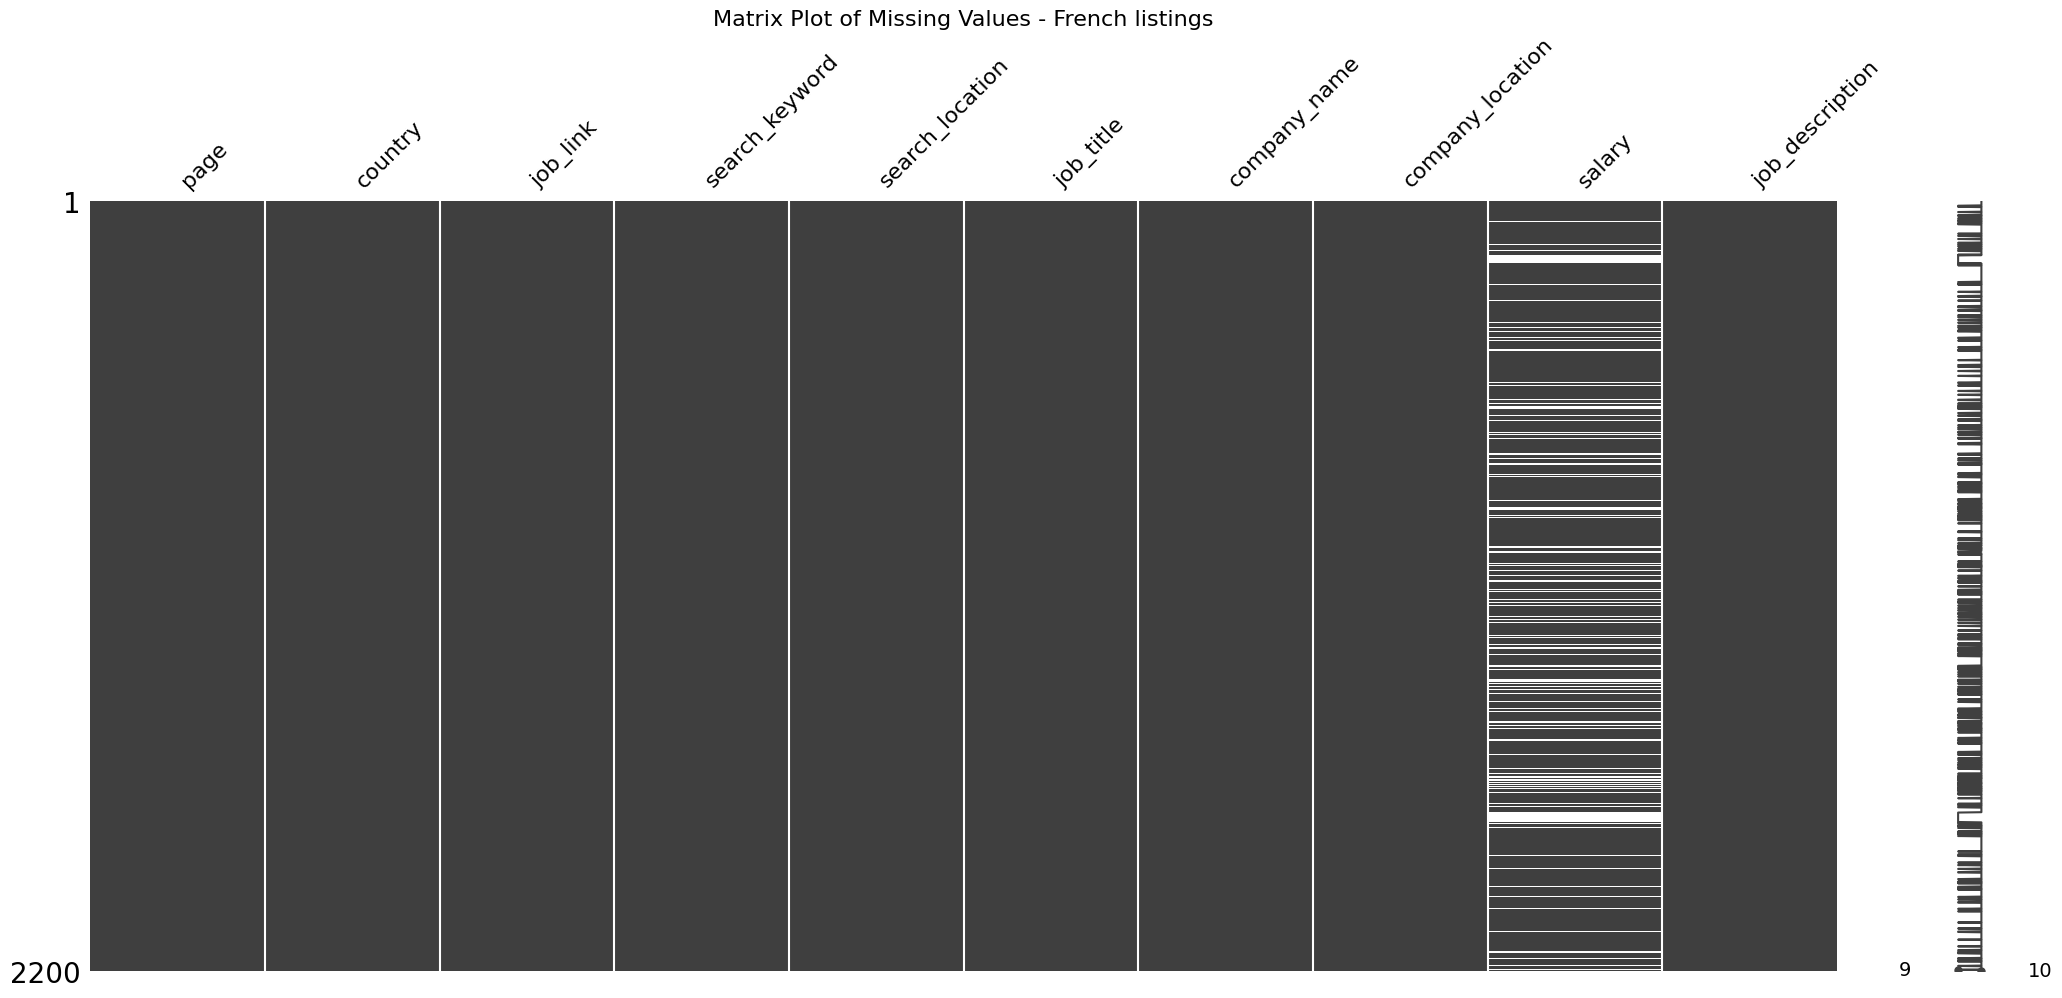

In [19]:
# Now the job_description should not have missing values anymore
msno.matrix(dfs['France'])
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  
plt.show()

In [20]:
# Verify consistent data types after the newly added info in job_description column
dfs['France'] = dfs['France'].astype(dicts.dtype_dict)
dfs['France'].dtypes

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object

### Check for duplicates

In [21]:
{mf.check_duplicates(df) for _, df in dfs.items()}

DataFrame with 320 rows has 0 duplicates.
DataFrame with 2200 rows has 0 duplicates.
DataFrame with 769 rows has 0 duplicates.
DataFrame with 1317 rows has 0 duplicates.


{None}

No rows are completely identical, but there are numerous examples of completely identical job descriptions. These are likely _reposts_ (the same job appearing multiple times, just with different unique links). We will remove rows where the job descriptions are identical if there is alsoan identical location and company name (or same urls), but first we have to normalize the job description (see below). 

### Clean columns

In [22]:
# Clean search_keyword and search_location columns: replace '+' with ' ' 
dfs = {country: df.assign(
   search_keyword=pd.Categorical(df['search_keyword'].astype(str).str.replace('+', ' ')),
   search_location=pd.Categorical(df['search_location'].astype(str).str.replace('+', ' '))
) for country, df in dfs.items()}
# Verify that it worked 
dfs['Sweden'].head(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...


In [23]:
# Clean job_title column 
dfs = {country: df.assign(
   job_title=df['job_title'].str.lower().pipe(
       lambda x: x.str.replace(r'\(?(h/f|f/h)\)?', '', regex=True).str.strip() 
       if country == 'France' else x
   )
) for country, df in dfs.items()}

In [24]:
# Merge all dfs in the dictionary into a single df
df_combined = pd.concat(dfs.values(), ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)
# Add dates when data was scraped 
df_combined['date'] = np.where(df_combined['country'].isin(['Sweden', 'USA']), pd.to_datetime('2024-09-19'), pd.to_datetime('2024-09-20'))
df_combined.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...,2024-09-19
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...,2024-09-19
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,data analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...,2024-09-19
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data Analyst,Stockholm,"juniora analysts till operations, engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning Deloitte är en glob...,2024-09-19


In [25]:
# Language identification for job descriptions (can take a little while)
df_combined['language'] = df_combined['job_description'].map(tf.detect_language)

In [26]:
# Assign job_id to each row, instead of using URLs as unique identifiers
df_combined.insert(0, 'job_id', range(1, len(df_combined) + 1))
df_combined.head(3)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language
0,1,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...,2024-09-19,en
1,2,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...,2024-09-19,en
2,3,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,data analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...,2024-09-19,en


In [27]:
# Normalize text data in job_description
normalized_descriptions = df_combined.groupby('language')[['job_description']].apply(tf.normalize_group)
normalized_descriptions = normalized_descriptions.reset_index()
df_combined = df_combined.reset_index(drop=True)
df_combined = pd.merge(df_combined, normalized_descriptions[['language', 'job_description', 'job_description_norm']], on=['language', 'job_description'], how='left')

Normalizing text for language group: en
Normalizing text for language group: fr
Normalizing text for language group: it
Normalizing text for language group: sv


In [28]:
df_combined[['job_description', 'job_description_norm']].head()

,job_description,job_description_norm
0,Data Analyst (Data Visualization) Swedium ...,data analyst data visualization swedium global...
1,Data Analyst (Data Visualization) Swedium ...,data analyst data visualization swedium global...
2,Role: Website Performance: Web analyst foc...,role website performance web analyst focus spe...
3,Role: Website Performance: Web analyst foc...,role website performance web analyst focus spe...
4,Responsibilities Website Performance: Web...,responsibility website performance web analyst...


In [29]:
# Now remove duplicates based on normalized job description. 
# Identify rows with same job description, company, and location (or unique url) and keep only the latest job listing
df_combined = mf.remove_duplicates_jobdesc(df_combined)

Initial rows: 10094
Rows after removing exact duplicates: 3028
Final rows: 3028
Total duplicates removed: 7066
--------------------------------------------------


In [30]:
# Check new row numbers after removing duplicates
row_counts = df_combined.groupby('country').size()
print("\nRow counts:\n", row_counts)


Row counts:
 country
France    1363
Italy      567
Sweden     263
USA        835
dtype: int64


In [31]:
# Map language codes to full language names 
df_combined['language'] = df_combined['language'].map(dicts.language_map)

In [32]:
# Clean and parse location column 
mask = df_combined['country']== 'USA'
df = df_combined[mask]['company_location']
df.to_csv('US_locations.csv', index=False)
df

7155                   New York, NY 10016
7156          Hybrid work in New York, NY
7159                   New York, NY 10016
7177          Hybrid work in New York, NY
7183                        Manhattan, NY
                       ...               
10088                        Rosemont, IL
10089          Hybrid work in Chicago, IL
10090    Hybrid work in Chicago, IL 60606
10091          Hybrid work in Chicago, IL
10093          Hybrid work in Chicago, IL
Name: company_location, Length: 835, dtype: object

In [82]:
#df_backup = df_combined
df_combined = df_backup 

In [83]:
countries = ['Sweden', 'France', 'Italy', 'USA']
countries

mapping_dict = {
   'France': (dicts.dept_mapping_fr, dicts.region_mapping_fr),
   'Sweden': (dicts.dept_mapping_se, dicts.region_mapping_se),
   'Italy': (dicts.dept_mapping_it, dicts.region_mapping_it), 
   'USA': (dicts.dept_mapping_us, dicts.region_mapping_us)
}

location_dfs = [mf.standardize_locations(df_combined[df_combined['country']==country], 
                                      'company_location',
                                      mapping_dict[country][0],
                                      mapping_dict[country][1],
                                      country) 
               for country in countries]

location_df = pd.concat(location_dfs)
df_combined = df_combined.merge(location_df, on=['job_id', 'company_location'], how='left')
df_combined = df_combined.drop('country_x', axis=1).rename(columns={'country_y': 'country'})

In [88]:
df_combined.head()

,job_id,page,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,job_description_norm,city_name,department,region,country
0,4,1,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19,english,company description statistic show woman under...,Stockholm,01 - Stockholm län,Stockholm,Sweden
1,8,1,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,Stockholm,fraud & data analyst to the fraud strategy & a...,Entercard Group AB,111 39 Stockholm,NaN,About Entercard Entercard is one of Scandin...,2024-09-19,english,entercard entercard one scandinavia’s leading ...,Stockholm,01 - Stockholm län,Stockholm,Sweden
2,12,1,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data Analyst,Stockholm,data analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,NaN,About Star Stable Entertainment Once upon a ...,2024-09-19,english,star stable entertainment upon time 2011 found...,Stockholm,01 - Stockholm län,Stockholm,Sweden
3,14,1,https://se.indeed.com/rc/clk?jk=7fa39868401ee6...,Data Analyst,Stockholm,data analyst,Baby Journey AB,114 51 Stockholm,NaN,Baby Journey lanserades hösten 2020 och är en ...,2024-09-19,swedish,baby journey lanserades hösten 2020 app riktar...,Stockholm,01 - Stockholm län,Stockholm,Sweden
4,16,2,https://se.indeed.com/rc/clk?jk=e8928767cb355b...,Data Analyst,Stockholm,oit-237 data classification and labeling analyst,WSP Sverige,111 20 Stockholm,NaN,WSP is a global consulting firm assisting pub...,2024-09-19,english,wsp global consulting firm assisting public pr...,Stockholm,01 - Stockholm län,Stockholm,Sweden


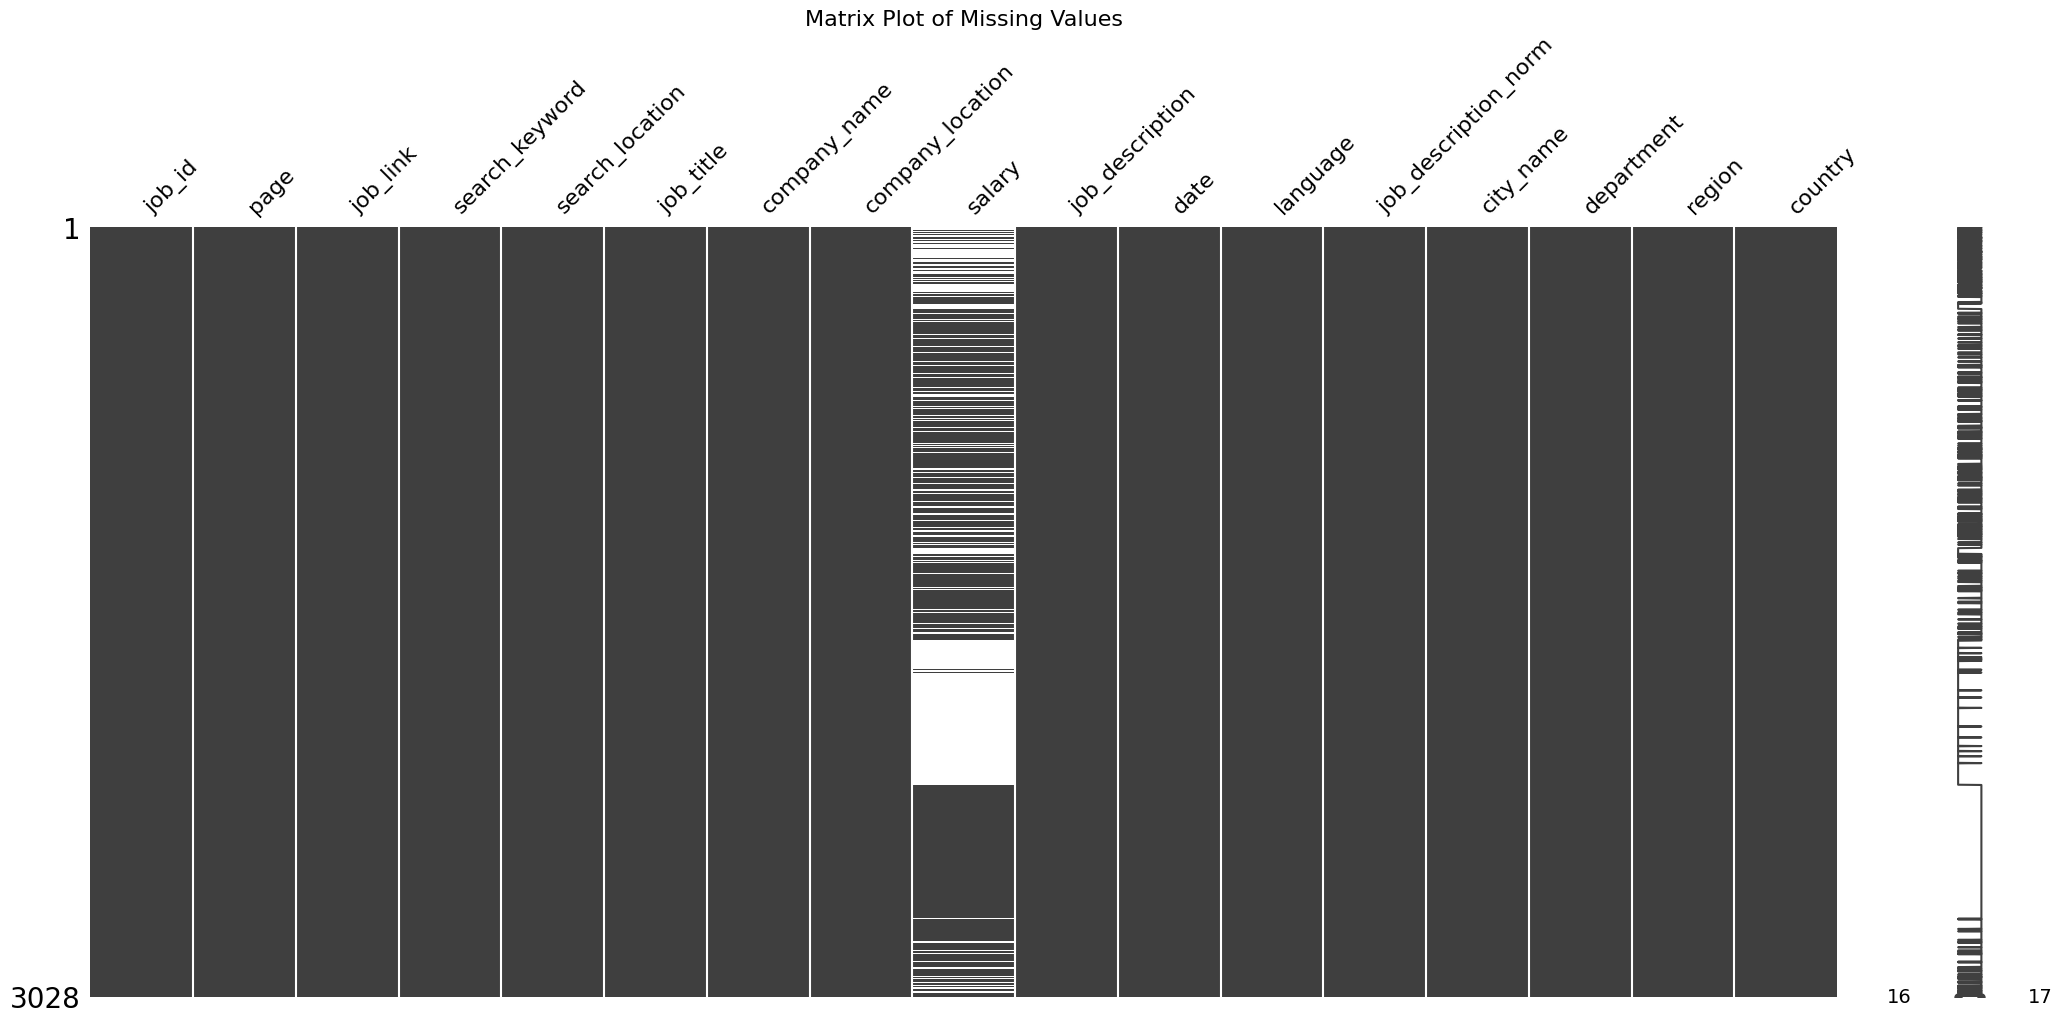

In [86]:
# Just verify that this didn't introduce new null values
msno.matrix(df_combined)
plt.title('Matrix Plot of Missing Values', fontsize=16)  
plt.show()

In [87]:
df_combined.dtypes

job_id                           int64
page                             int64
job_link                        object
search_keyword                category
search_location                 object
job_title               string[python]
company_name            string[python]
company_location                object
salary                          object
job_description         string[python]
date                    datetime64[ns]
language                        object
job_description_norm            object
city_name                       object
department                      object
region                          object
country                 string[python]
dtype: object

In [37]:
# Verify data types for new columns (compare to dicts.dtype_dict)
df_combined.dtypes

job_id                           int64
page                             int64
country                 string[python]
job_link                        object
search_keyword                category
search_location                 object
job_title               string[python]
company_name            string[python]
company_location                object
salary                          object
job_description         string[python]
date                    datetime64[ns]
language                        object
job_description_norm            object
dtype: object

In [90]:
df_combined = df_combined.astype({
    'job_id': 'int64',
    'language': 'category',
    'job_description_norm': 'string',
    'city_name' : 'string',  
    'country' : 'category' 
})
df_combined.dtypes

job_id                           int64
page                             int64
job_link                        object
search_keyword                category
search_location                 object
job_title               string[python]
company_name            string[python]
company_location                object
salary                          object
job_description         string[python]
date                    datetime64[ns]
language                      category
job_description_norm    string[python]
city_name               string[python]
department                      object
region                          object
country                       category
dtype: object

In [39]:
df_combined.head(3)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,job_description_norm
6,4,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19,english,company description statistic show woman under...
13,8,1,Sweden,https://se.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data Analyst,Stockholm,fraud & data analyst to the fraud strategy & a...,Entercard Group AB,111 39 Stockholm,NaN,About Entercard Entercard is one of Scandin...,2024-09-19,english,entercard entercard one scandinavia’s leading ...
20,12,1,Sweden,https://se.indeed.com/rc/clk?jk=27fb82edf82fcd...,Data Analyst,Stockholm,data analyst,Star Stable Entertainment,Distansjobb in 118 27 Stockholm,NaN,About Star Stable Entertainment Once upon a ...,2024-09-19,english,star stable entertainment upon time 2011 found...


## Descriptive statistics

In [40]:
# Describe (numerical) columns  
mask = df_combined['country'] == 'Sweden'
df_combined[mask].describe(include='all').head()

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,job_description_norm
count,263.000000,263.000000,263,263,263,263,263,263,263,113,263,263,263,263
unique,NaN,NaN,1,263,4,3,194,198,88,10,263,NaN,2,263
top,NaN,NaN,Sweden,https://se.indeed.com/rc/clk?jk=132e951bba6ac1...,Data Scientist,Stockholm,systemutvecklare,Cubane Solutions AB,Stockholm,Heltid,We are hiring a GIS Analyst Nordregio is exp...,NaN,english,hiring gi analyst nordregio expanding gi team ...
freq,NaN,NaN,263,1,131,186,19,7,69,58,1,NaN,133,1
mean,169.490494,2.593156,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-19 00:00:00,NaN,NaN


In [41]:
# Describe categorical columns  
af.desc_categorical(df_combined[mask])

Value counts for column: country
country
Sweden    263
Name: count, dtype: Int64

Value counts for column: job_title
job_title
systemutvecklare                                 19
data analyst                                     13
data scientist                                   13
business analyst                                  8
senior data scientist                             5
                                                 ..
pricing coordinator                               1
senior business intelligence analyst              1
senior logistics analyst                          1
powerbi utvecklare                                1
production analytics lead [game intelligence]     1
Name: count, Length: 194, dtype: Int64

Value counts for column: company_name
company_name
Cubane Solutions AB      7
Deploja AB               6
JobBusters AB            4
Volvo Group              4
TEN10 AB                 4
                        ..
Techster Solutions       1
JAS Worldwide        

### Preliminary observations, Swedish job listings:
- __Most frequent job title__: Systemutvecklare.
- __Most frequent company__: Cubane Solutions AB. 
- __Company location__: Stockholm primarily. 
- __Salary ranges__: Few numerical values.

In [42]:
mask = df_combined['country'] == 'France'
df_combined[mask].describe(include='all').head(4)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,job_description_norm
count,1365.0,1365.0,1365,1365,1365,1365,1365,1365,1365,1108,1365,1365,1365,1365
unique,NaN,NaN,1,1365,4,3,1151,718,256,164,1350,NaN,2,1343
top,NaN,NaN,France,https://www.indeed.fr/rc/clk?jk=87348216f5b0a7...,Product Analyst,Paris (75),data analyst,AXA,Paris (75),Temps plein,The Sandbox is a user-generated content virtua...,NaN,french,entité lagardère travel retail duty free globa...
freq,NaN,NaN,1365,1,502,1200,38,39,380,298,2,NaN,982,2


In [43]:
af.desc_categorical(df_combined[mask]) 

Value counts for column: country
country
France    1365
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                                                                            38
data scientist                                                                                          32
business analyst                                                                                        13
data analyst intern                                                                                      8
business analyst data                                                                                    7
                                                                                                        ..
apprenticeship - business data analyst - september 2024 - (m/f)                                          1
alternance - assistant data analyst                                                                      1
business analyst

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job title__: Data Analyst. 
- __Most frequently mentioned company__: AXA. 
- __Company location__: Most in Paris. 
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [44]:
mask = df_combined['country'] == 'Italy'
df_combined[mask].describe(include='all').head(4)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,job_description_norm
count,568.0,568.0,568,568,568,568,568,568,568,17,568,568,568,568
unique,NaN,NaN,1,568,4,3,451,309,96,14,552,NaN,3,554
top,NaN,NaN,Italy,https://it.indeed.com/rc/clk?jk=46de7544ab716b...,Data Analyst,"Milano, Lombardia",data scientist,BIP - Business Integration Partners,"Milano, Lombardia",1.000 € al mese,"NTT DATA, Trusted Global Innovator, è tra i pr...",NaN,italian,ntt data trusted global innovator è tra princi...
freq,NaN,NaN,568,1,261,389,33,30,148,3,3,NaN,314,3


In [45]:
af.desc_categorical(df_combined[mask])

Value counts for column: country
country
Italy    568
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data scientist                      33
data analyst                        16
business analyst                    11
senior data analyst                  6
cyber security analyst               4
                                    ..
senior business analyst              1
data scientist middle                1
bi engineer                          1
junior business analyst autohero     1
analista programmatore cobol         1
Name: count, Length: 451, dtype: Int64

Value counts for column: company_name
company_name
BIP - Business Integration Partners    30
NTT Data                               16
KPMG                                   14
DXC Technology                         11
Euronext                               10
                                       ..
Rosetti Marino spa                      1
EF Solare Italia                        1
Advancia          

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job title__: Data Scientist.
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. 
- __Salary ranges__: Few numerical entries. 

In [46]:
mask = df_combined['country']=='USA'
df_combined[mask].describe(include='all').head(4)

,job_id,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,job_description_norm
count,835.0,835.0,835,835,835,835,835,835,835,789,835,835,835,835
unique,NaN,NaN,1,835,4,3,737,470,185,524,823,NaN,1,823
top,NaN,NaN,USA,https://www.indeed.com/rc/clk?jk=274ddb9b95715...,Data Scientist,"New York, NY",data analyst,Citi,"New York, NY",Full-time,Wavemaker positively provokes growth for clien...,NaN,english,wavemaker positively provokes growth client re...
freq,NaN,NaN,835,1,264,487,12,27,179,149,2,NaN,835,2


In [47]:
af.desc_categorical(df_combined[mask])

Value counts for column: country
country
USA    835
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                                   12
business analyst                                               11
senior machine learning engineer                                9
senior data scientist                                           8
senior business analyst                                         5
                                                               ..
sales analyst                                                   1
healthcare claims api/edi business analyst (local) (hybrid)     1
ecommerce analyst                                               1
senior financial analyst, north america commercial finance      1
business analyst, performance internal controls                 1
Name: count, Length: 737, dtype: Int64

Value counts for column: company_name
company_name
Citi                        27
JPMorganChase               

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job title__: Data Analyst. But titles need to be looked at in detail to get the full picture (there are terms such as 'senior' that will result in separate categories when counting values)
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to look into the numerical entries only.

## Feature engineering 

### Retrieve numeric values for salary

In [ ]:
df_combined.head()

In [ ]:
for country in df_combined['country'].unique():
    mask = df_combined['country'] == country
    unique_langs = df_combined[mask]['language'].unique().tolist()
    print('*' * 30, f'Retrieving salaries for {country}:', f'Languages: {unique_langs}', sep='\n')
    result = sf.parse_salary_column(df_combined[mask], languages=unique_langs, country=country, time_keyword_dict=dicts.time_keywords)
    print(f'Rows changed for {country}: {result.shape[0]}. Original rows retrieved: {df_combined[mask].shape[0]}')
    assert result.shape[0]==df_combined[mask].shape[0]
    if result.shape[0] != df_combined[mask].shape[0]:
        print(f"Warning: Size mismatch for {country}. Expected {df_combined[mask].size}, got {result.size}")
        break 
    columns_to_update = ['min_salary', 'max_salary', 'currency', 'time_unit']
    df_combined.loc[mask, columns_to_update] = result[columns_to_update]
    print('*' * 30 + '\n')

In [ ]:
df_combined.head()
df_combined.info()

In [ ]:
print('Sample of updated data:')
print(df_combined[df_combined['salary'].notna()][['country', 'salary', 'min_salary', 'max_salary', 'currency', 'time_unit']].sample(5))

In [ ]:
# Check missing values now 
msno.matrix(df_combined)
plt.title('Matrix Plot of Missing Values - All countries', fontsize=16)  
plt.show()

In [ ]:
# Make sure data types are correct again
df_combined.dtypes

In [ ]:
# Get monthly salary for all rows 
df_combined['min_salary_monthly'] = sf.convert_salary_to_monthly(df_combined, 'min_salary', 'time_unit')
df_combined['max_salary_monthly'] = sf.convert_salary_to_monthly(df_combined, 'max_salary', 'time_unit')
df_combined[df_combined['min_salary_monthly'].notna()].head(3)

In [ ]:
# Convert salary to same currency using exchange rate
df_combined = sf.process_salaries(df_combined)

In [ ]:
# Verify correct data types 
# Convert currency, time_unit into categorical 
df_combined[['currency', 'time_unit']] = df_combined[['currency', 'time_unit']].astype('category')
df_combined[['min_salary_month_EUR', 'max_salary_month_EUR']] = df_combined[['min_salary_month_EUR', 'max_salary_month_EUR']].astype('Float64')
df_combined.dtypes

### Detect keywords : overall

In [ ]:
# Extract keywords for countries
common_keywords = pd.Series(dicts.countries_languages).apply(
    lambda x: tf.extract_keywords(df_combined, x[0], x[1]))

# Access keywords for specific country
common_keywords['SWE'][0]

### Detect keywords : technical skills

In [ ]:
# Create keyword counts for different countries 
technical_skills = pd.concat([
    af.count_keywords(df_combined, country_name, dicts.software_keywords, 'job_description_norm')
    for _, (country_name, _) in dicts.countries_languages.items()
], ignore_index=True).sort_values('Count', ascending=False)
technical_skills.head()

In [ ]:
# Relative frequency of keyword for resp. country and search keyword
skills_country = af.calculate_country_frequencies(technical_skills, df_combined)

# View top skills for each country
top_skills_by_country = skills_country.sort_values(['Country', 'Frequency'], ascending=[True, False]).groupby('Country').head(10)
top_skills_by_country

In [ ]:
# Top 10 keywords overall
global_skills = af.calculate_global_frequencies(technical_skills, df_combined)
global_skills.head(10)

In [ ]:
skills_by_role = af.calculate_frequencies_by_search_keyword(technical_skills, df_combined)

# Get top 10 skills for each search keyword
top_skills_by_role = skills_by_role.groupby('Search Keyword', observed=True).head(10)
top_skills_by_role

### Detect keywords : interview process

In [ ]:
dicts.context_patterns

In [ ]:
# Extract interview information
interview_info_df, interview_flags_df = tf.extract_interview_details(df_combined, 
                                                                  dicts.interview_stages, 
                                                                  dicts.context_patterns, 
                                                                  'job_description_norm', 
                                                                  'language')

# Sum Boolean columns in interview_flags_df to count occurrences of each interview stage
stage_counts = interview_flags_df.select_dtypes(include='bool').sum()
stage_counts

In [ ]:
# Example: run this to retrieve text about technical interviews
#interview_info_df[interview_info_df['technical_screening_text'].notna()]

Information about the interview process seems to mostly be missing/left out from the job listnings. However, the most common category appears to be phone/video call screenings, followed by case studies. 

## Analysis and visualizations


### Categorical features

In [ ]:
# Plot common keywords 
categorical_plots = {
    country_name: pf.plot_common_keywords(common_keywords[code][0], country_name)
    for code, (country_name, *_) in dicts.countries_languages.items()
}

In [ ]:
# Word cloud visualizations per country
for code, (name, _) in dicts.countries_languages.items():
    pf.plot_wordtree(common_keywords[code][1], name)

In [ ]:
technical_skills.head()

In [ ]:
pf.plot_stacked_bar_chart(technical_skills)

In [ ]:
# Skills for different roles 
pf.plot_top_keyword_heatmap(technical_skills)

In [ ]:
pf.plot_skills_bars(top_skills_by_role)

In [ ]:
#plot_pentagon_keywords(top_skills_by_role)

In [ ]:
pf.plot_keywords_per_group_subplots(df=technical_skills, group_col='Category', keyword_col='Keyword', count_col='Count', n_top=10)

In [ ]:
top_skills_by_country.head()
pf.plot_keywords_per_group_subplots(df=skills_country, group_col='Country', keyword_col='Keyword', count_col='Frequency', n_top=20)

In [ ]:
global_skills.head()

In [ ]:
import squarify 

# Group data by category and sum up the counts
grouped_data = global_skills.groupby(['Category', 'Keyword'])['Count'].sum().reset_index()

# Filter top 10 keywords per category
top_keywords = grouped_data.groupby('Category').head(3)

# Create a color palette
colors = sns.color_palette("pastel", len(top_keywords['Category'].unique()))

# Create the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=top_keywords['Count'], label=top_keywords['Keyword'], alpha=.8, color=colors)
plt.axis('off')
plt.title('Hierarchical Treemap of Top 3 Keywords by Category')
plt.show()

In [ ]:
# Group the data by 'Keyword' and count the occurrences
keyword_counts = global_skills.groupby('Keyword').size()

# Check if 'Databricks' occurs more than once
if keyword_counts['databricks'] > 1:
    print("databricks occurs in multiple categories.")
else:
    print("Databricks occurs in only one category.")


In [ ]:
# Filter the DataFrame for rows containing "Databricks"
databricks_rows = global_skills[global_skills['Keyword'] == 'docker']

# Get the unique categories
categories_with_databricks = databricks_rows['Category'].unique()

print(categories_with_databricks)

# Make sure there is no overlap between different categories 
# docker, databricks


In [ ]:
# Categorical variables
categorical_cols = ['search_keyword', 'country', 'job_title', 'company_name', 'company_location']

In [ ]:
pf.plot_grouped_bar(
    df_combined,
    group_col='country',
    value_col='company_location',
    title='Top Locationd by Country'
)

In [ ]:
# Plot top company names per country
pf.plot_grouped_bar(
    df_combined,
    group_col='country',
    value_col='company_name',
    title='Top Companies by Country'
)

In [ ]:
# For job titles by country
pf.plot_grouped_bar(
    df_combined,
    group_col='country',
    value_col='job_title',
    title='Top Job Titles by Country'
)

### Numerical features

In [ ]:
# Summary statistics and boxplots for salary (outliers with jitter to more easily see them)
salary_cols = ['min_salary_month_EUR', 'max_salary_month_EUR']
outliers_df, outlier_rows = pf.plot_boxplot(df_combined, salary_cols)

print('Summary statistics for salary columns:')
print(df_combined[salary_cols].describe().round(2)) 

In [ ]:
outlier_rows[['search_keyword', 'country', 'company_location', 'job_title', 'job_description_norm', 'min_salary_month_EUR', 'max_salary_month_EUR', 'outlier_source']]

What are these outliers representing and where are they coming from? 
- All from USA (mostly NY). 
- Founder, director, vice president, VP, and other senior roles. 

Lets also look at the smallest salaries and where they come from. 

In [ ]:
# Get min salaries and see if there is a pattern
min_salaries = (df_combined
                  .dropna(subset=['min_salary_month_EUR'])  # Remove rows with NA salaries
                  .nsmallest(10, 'min_salary_month_EUR')
                  [['search_keyword', 'job_title', 'company_name', 'country', 'company_location', 'min_salary_month_EUR', 'salary']])

min_salaries

The lowest salaries are from France and Italy, for internships, 'alternance', and junior roles. 

In [ ]:
# Get top salaries in France and see if there is a pattern
top_fr_salaries = (df_combined[df_combined['country'] == 'France']
                  .dropna(subset=['max_salary_month_EUR'])  # Remove rows with NA salaries
                  .nlargest(10, 'max_salary_month_EUR')
                  [['search_keyword', 'job_title', 'company_name', 'company_location', 'max_salary_month_EUR', 'salary']])

top_fr_salaries

Highest salaries in France are for indépendant / freelance jobs in Paris, paid by day rate. 

In [ ]:
pf.plot_grouped_histograms(
    df_combined, 
    group_col = 'country', 
    value_col = salary_cols[0], 
    bins = 10, 
    kde = True, 
    title = 'Min Salary Distribution'
)

pf.plot_grouped_histograms(
    df_combined, 
    group_col = 'country', 
    value_col = salary_cols[1], 
    bins = 10, 
    kde = True, 
    title = 'Max Salary Distribution'
)

In [ ]:
salary_ranges = (
    df_combined
    .groupby('country')
    .agg({
        'min_salary_month_EUR': 'min',
        'max_salary_month_EUR': 'max'
    })
    .rename(columns={
        'min_salary_month_EUR': 'Lowest Monthly Salary (EUR)',
        'max_salary_month_EUR': 'Highest Monthly Salary (EUR)'
    })
)

salary_ranges

Lets look into the second peaks (e.g. max salary for France, with second peak after 10 000 EUR). 

In [ ]:
# Filter by country 
filtered_df = df_combined[(df_combined['country'] == 'France') & 
                         (df_combined['min_salary_month_EUR'].notna())]

# Filter salary range 
filtered_df = filtered_df[(filtered_df['max_salary_month_EUR'] > 10000) & 
           (filtered_df['max_salary_month_EUR'] < 16000)]

filtered_df.head()

In [ ]:
identical_cols = filtered_df.apply(lambda x: len(x.unique()) == 1)
print("Columns with identical values:", identical_cols[identical_cols].index.tolist())
print("\nThe identical values are:")

for col in identical_cols[identical_cols].index:
    print(f"{col}: {filtered_df[col].iloc[0]}")

filtered_df[filtered_df.apply(lambda x: len(x.unique()) == 1).index].head()

Observations: 
- **Sweden**: Only has 2 data points. This was the smallest dataset but it also makes sense that there are few values isnce Swedish interview processes usually do not involve discussing salaries until the very end of the rounds. 
- **France**: It almost looks like there are two peaks. This is because we have several rows with high salaries for freelance work in Paris. 
- **Italy**: Also has a second peak for jobs in Milano. But this is also be since we have fewer data points. 
- **USA**: Significantly higher salaries overall, as to be expected. 

In [ ]:
def plot_salary_by_keyword(df: pd.DataFrame, figsize: tuple[int, int] = (10, 6)) -> None:
    """Create boxplot of salaries by search keyword for France."""
    plt.figure(figsize=figsize)
    
    sns.boxplot(
        data=df.query("country == 'France'"),
        x='search_keyword',
        y='max_salary_month_EUR',
        color='mediumseagreen',
        width=0.5
    )
    
    plt.xlabel('Job Title')
    plt.ylabel('Maximum Monthly Salary (EUR)')
    plt.title('Salary Distribution by Job Title in France')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Use it like this:
plot_salary_by_keyword(df_combined)

In [ ]:
pf.plot_grouped_histograms(
    df_combined, 
    group_col='search_keyword', 
    value_col='min_salary_month_EUR', 
    bins=10, 
    kde=True, 
    title='Min Salary Distribution by Job Title'
)

pf.plot_grouped_histograms(
    df_combined, 
    group_col='search_keyword', 
    value_col='max_salary_month_EUR', 
    bins=10, 
    kde=True, 
    title='Max Salary Distribution by Job Title'
)

## Bivariate analysis 

In [ ]:
## Bivariate and Multivariate Analysis
# - Pairwise correlations
# - Relationships between key variables
# Statistical tests to see if there are significant differences in salaries for these search terms 

In [ ]:
def plot_box(df: pd.DataFrame, 
            y: str = 'max_salary_month_EUR',
            x: str = 'company_location',
            hue: str = 'job_title',
            figsize: tuple[int, int] = (10, 6)) -> None:
    """
    Create boxplot showing salary distribution by location and job title.
    """
    plt.figure(figsize=figsize)
    
    sns.boxplot(
        data=df,
        x=x,          # locations on x-axis
        y=y,          # salary on y-axis
        hue=hue,      # separate boxes by job title
        width=0.8
    )
    
    plt.xlabel('Company Location')
    plt.ylabel('Maximum Monthly Salary (EUR)')
    plt.title('Salary Distribution by Job Title and Location')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Get the 10 most common locations
common_locations = (df_combined
                   .query("country == 'France'")
                   ['company_location']
                   .value_counts()
                   .nlargest(10)
                   .index)

# Plot using filtered data
plot_box(
    df=df_combined.query("country == 'France' and company_location in @common_locations"),
    y='max_salary_month_EUR', 
    x='company_location', 
    hue='search_keyword',
    figsize=(12, 6)
)

In [ ]:
# Disregarding the country in question, are data scientist salaries significantly higher?

In [ ]:
# Create salary bins
df_combined['salary_range'] = pd.qcut(
    df_combined['min_salary_month_EUR'], 
    q=4,  # Creates 4 equal-sized groups
    labels=['Low', 'Medium-Low', 'Medium-High', 'High']
)

# Create the plot with correct color syntax
sns.countplot(
    data=df_combined, 
    x='search_keyword', 
    hue='salary_range',
    palette='Greens'  # Using a green color palette
)
plt.xticks(rotation=45, ha='right')
plt.title('Count of Job Titles by Salary Range')
plt.tight_layout()
plt.show()

In [ ]:
sns.countplot(data=df_combined, x='search_keyword', hue='country')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Country')
plt.show()

Why are there tons of Product Analyst jobs in France? Also tons of BI Analyst jobs. 
    
There are a bunch of data analyst (also data scientist) jobs that are very well paid. Do they have anything in common? 

In [ ]:
import scipy.stats as stats
salary_ranges = pd.cut(df_combined['min_salary_month_EUR'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=['<20k', '20-40k', '40-60k', '60-80k', '80-100k'])
crosstab = pd.crosstab(df_combined['search_keyword'], salary_ranges)
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f'Chi-squared: {chi2}, p-value: {p}')

In [ ]:
# Create pivot table with NA handling
pivot_table = df_combined.pivot_table(
    values='max_salary_month_EUR', 
    index='country', 
    columns='search_keyword', 
    aggfunc='mean', 
    observed=True
)

# Convert NA values to numbers that seaborn can handle
pivot_table = pivot_table.astype(float)

# Create heatmap
plt.figure(figsize=(12, 6))  # Adjust size as needed
sns.heatmap(
    pivot_table, 
    annot=True,  # Show values
    cmap='YlGnBu',  # Color scheme
    fmt='.0f',  # Round to 0 decimal places
    cbar_kws={'label': 'Average Max Salary (EUR)'}
)

plt.title('Average Salary Heatmap by Country and Job Title')
plt.tight_layout()
plt.show()

In [ ]:
# Create pivot table excluding USA and Sweden
pivot_table = (df_combined[~df_combined['country'].isin(['USA', 'Sweden'])]
               .pivot_table(
                   values='max_salary_month_EUR', 
                   index='country', 
                   columns='search_keyword', 
                   aggfunc='mean', 
                   observed=True
               ))

# Convert NA values to numbers
pivot_table = pivot_table.astype(float)

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_table, 
    annot=True, 
    cmap='YlGnBu',
    fmt='.0f',
    cbar_kws={'label': 'Average Max Salary (EUR)'}
)

plt.title('Average Salary Heatmap by Country and Job Title (France and Italy)')
plt.tight_layout()
plt.show()

## Conclusions 

### Categorical features: 
- Common keywords: 
- Technical skills required: 
- Interview process: 
- Locations: 
    
### Numerical features: 
- Salaries: 
- Salaries that stood out:
- Combinations that led to high salary: 
- Locations versus salaries: 

Salaries: 
- As expected, salaries are significantly higher in the US. For some reason, maximum salaries appear to be for Data Analyst jobs?
- If you want to be well paid in Europe, it seems like a good idea to become a Data Scientist in Sweden, or Product Analyst in France or Italy. There are tons of jobs that fell under the 'Product Analyst' title for France. Have to look into this. It would be worth looking into the job descriptions of these titles in France and Italy to understand this better. There are too few data points for Sweden. 

- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 
- Clean up job titles for different countries? The search algorithm actually is pretty bad? 

### Suggestions for future work
Analysis


In [ ]:
# Save CSV files

# Need to retrieve location data for Tableau?  